# Forecasting Vaccination Trends with Time Series Models

## Introduction

In this notebook, I'll explore two topics:

1. Trends and predictions on vaccinations in the four most populous US cities, using time series modeling

The goal here will be to understand how each city is trending over time and explore similarities/differences, as well as look at how the forecast looks for future vaccinations. 

2. How vaccination trends correlate to social media sentiment over time, based on my Twitter data labeled with Textblob'S polarity score

Here I'll run a correlation analysis to see how closely the trends in social media sentiment match the trends in vaccines administered in each city, and analyze the results.

To start, I am going to import all of the vaccine data gathered from the four cities, New York, Chicago, Houston, and LA, in the timeframe of 1/1/21-6/15/21. The vaccination data was pulled from each respective city's health department, so all files are slightly different in the information they're supplying. The first part of the notebook focuses on cleaning and inspecting the data before moving on to time series analysis.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

import numpy as np

#data exploration
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


#modeling
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

#evaluation metrics
import scipy.stats as stats
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing all files
nyc = pd.read_csv('data/nyc.csv')
houston = pd.read_csv('data/Houston.csv')
la = pd.read_csv('data/la.csv')
chicago = pd.read_csv('data/chicago.csv')

## Data Cleaning

After importing all packages and files, I am going through to make sure each has a consistent format including date range and column name for the target variable. I also am labeling each city within the dataframe for when I merge them. 

In [3]:
# adding location column
nyc['city'] = 'new york'  

# converting dates to datetime
nyc['date'] = pd.to_datetime(nyc['DATE'])  

# filtering to consistent timeframe
new_nyc = nyc[nyc['date'] >= '2021-01-01'] 

# getting consistent column name for vaccines administered
new_nyc['total_doses'] = new_nyc['ADMIN_ALLDOSES_DAILY']

In [4]:
# repeating steps with houston

houston['date'] = pd.to_datetime(houston['Date_str'])

new_houston = houston[(houston['date'] >= '2021-01-01')
                      & (houston['date'] <= '2021-06-15')]

new_houston['total_doses'] = new_houston['Vaccinated']

# need to do a groupby since there are multiple readings from each date
new_houston = new_houston.groupby(['date'], as_index=False).sum()
new_houston['city'] = 'houston'  # adding location column after groupby

In [5]:
#also need to difference the data as it is cumulative
new_houston['total_doses'] = new_houston['total_doses'].diff()

In [6]:
#chicago
chicago['city'] = 'chicago'
chicago['date'] = pd.to_datetime(chicago['Date'])
chicago['total_doses'] = chicago['Total Doses - Daily']
new_chicago = chicago[chicago['date'] >= '2021-01-01']

In [7]:
#los angeles, also need to group by date
la['date'] = pd.to_datetime(la['Date (Dose 1)'])
new_la = la[la['date'] >= '2021-01-01']
new_la = new_la.groupby(['date'], as_index=False).sum()
new_la['city'] = 'los angeles'
new_la['total_doses'] = new_la['Dose1_all']

I'm writing a function to run each dataframe through to format with only the columns I want. Then I'll look at the data overall.

In [8]:
def to_format(dataframe):
    
    """preps dataframe for time series formatting"""
    
    city_subset = dataframe[['date', 'city', 'total_doses']]
    return(city_subset)

In [9]:
nyc_format = to_format(new_nyc)
houston_format = to_format(new_houston)
chicago_format = to_format(new_chicago)
la_format = to_format(new_la)

In [10]:
#combining dataframes
combined = pd.concat([nyc_format, houston_format, chicago_format, la_format],
                     ignore_index=True, sort=False).sort_values(by='date')

time_indexed_combined = combined.set_index('date')

time_indexed_combined.head()

,city,total_doses
date,,
2021-01-01,new york,167.0
2021-01-01,houston,NaN
2021-01-01,los angeles,1112.0
2021-01-01,chicago,48.0
2021-01-02,houston,2737.0


It looks like the overall trend is that the # vaccines per day peaked in April, when most places started making the vaccine available to more of the population. After that, the decline is pretty sharp. In the next section we'll see how this differs (or not) by location)

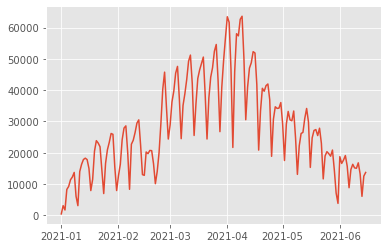

In [11]:
ti_mean = time_indexed_combined.groupby('date').mean()
plt.plot(ti_mean)

Overall, the trend seems to show that vaccines administered steadily increased until they hit their peak in April. In this timeframe in most areas, the vaccine was only available to people 60+ and medical professionals/essential workers, so we see that part of the population turned out. Vaccines became available and accessible to the general population in April-May, so the data suggests the people most eager to get the vaccine did so as soon as possible, but the rollout slowed down pretty dramatically from there.

The dip in mid-February coincides with some extreme winter weather, especially in Texas where a storm caused widespread emergency conditions and power outages. 

## Creating Time Series 

Now that I've cleaned and inspected the data, I'm going to format each city's dataframe for time series modeling.

Looking at the chart below, I can get an idea of how the volume of vaccinations differ from place to place, where New York City is seeing a much higher volume than Houston overall. 

In [12]:
#formatting for time series model
nyc_ts = nyc_format.set_index('date')['total_doses']
hou_ts = houston_format.set_index('date')['total_doses']
chi_ts = chicago_format.set_index('date')['total_doses']
la_ts = la_format.set_index('date')['total_doses']

In [13]:
#due to the groupby there is 1 null in the houston data
hou_ts = hou_ts.dropna()

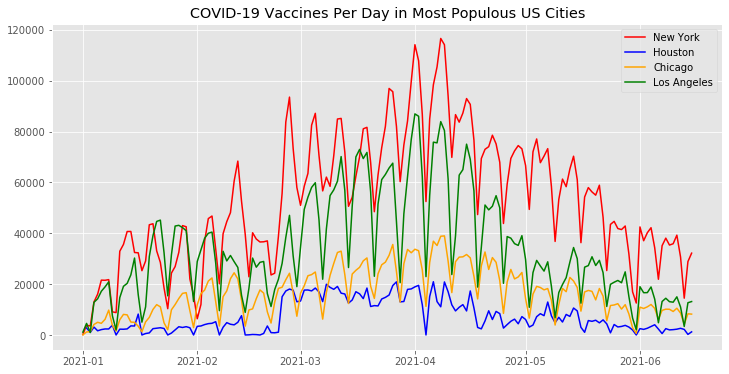

In [14]:
fig = plt.figure(figsize=(12,6))
plt.plot(nyc_ts, label='New York', color='red')
plt.plot(hou_ts, label='Houston', color='blue')
plt.plot(chi_ts, label='Chicago', color='orange')
plt.plot(la_ts, label='Los Angeles', color='green')
plt.title("COVID-19 Vaccines Per Day in Most Populous US Cities")
plt.legend()
# plt.savefig('Images/vaccines_per_day.png')

## Checking for Trends

In each city there appear to be periodic trends, which would violate the assumption of stationarity that I'd need for a time series model to be effective. Below I am going to run a test to check if my data is stationary.

The function below will compare the rolling mean and standard deviation of each city for a visual of the trends, as well as run the Dickey-Fuller test. If the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary.

In [15]:
def stationarity_plot(data, city):
    
    """
    Calcuates and plots rolling mean and rolling standard deviation
    for each time series against the original data and outputs 
    results from Dickey-Fuller test to assess stationarity. 
    
    """
    
    roll_mean = data.rolling(window=7, center=False).mean()
    roll_std = data.rolling(window=7, center=False).std()
    
    dftest = adfuller(data)

    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(city))
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test for {}: \n'.format(city))

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

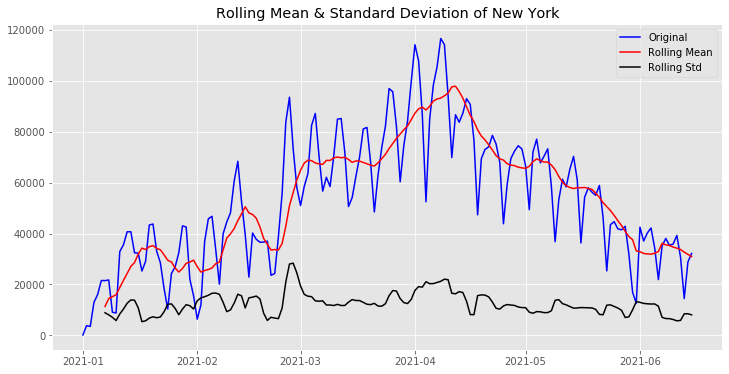

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -1.198953
p-value                          0.674046
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


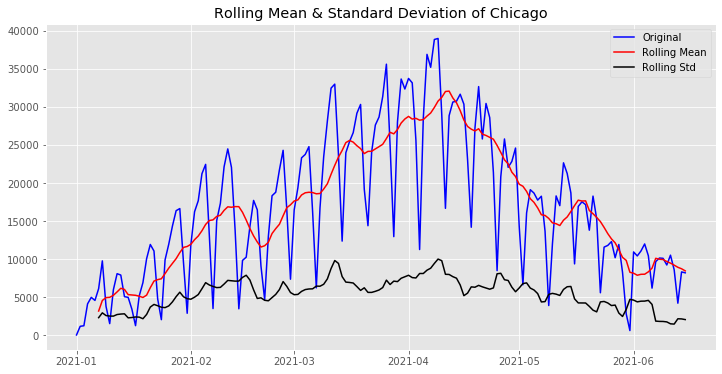

Results of Dickey-Fuller Test for Chicago: 

Test Statistic                  -1.712065
p-value                          0.424907
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


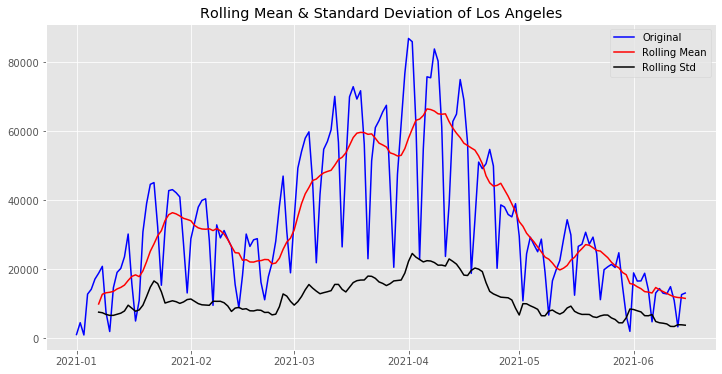

Results of Dickey-Fuller Test for Los Angeles: 

Test Statistic                  -1.547956
p-value                          0.509669
#Lags Used                       8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


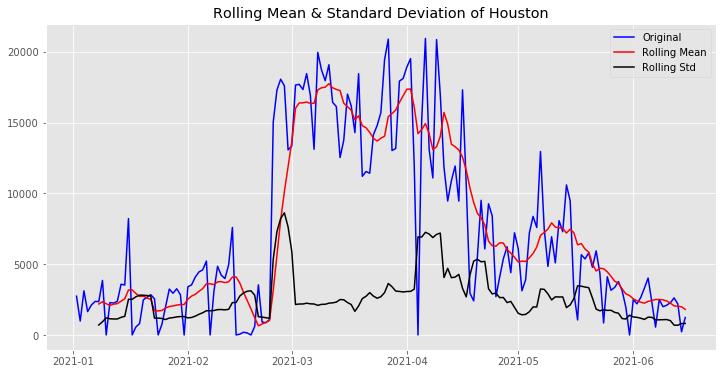

Results of Dickey-Fuller Test for Houston: 

Test Statistic                  -1.540347
p-value                          0.513466
#Lags Used                       7.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [16]:
stationarity_plot(nyc_ts, 'New York')
stationarity_plot(chi_ts, 'Chicago')
stationarity_plot(la_ts, 'Los Angeles')
stationarity_plot(hou_ts, 'Houston')

Results uphold the null hypothesis: the time series is not stationary for any of the cities. This means I will need to factor non-stationarity into my model.

To get a deeper understanding of the underlying trends, I'm going to use statsmodels's decomposition tool and run each of my cities' data throuugh a function that visualizes it. 

In [17]:
def decompose(ts):
    
    """
    plots statsmodels's seasonal decomposition charts
    to visualize underlying trends in data
    """
    
    decomposition = seasonal_decompose((ts))

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

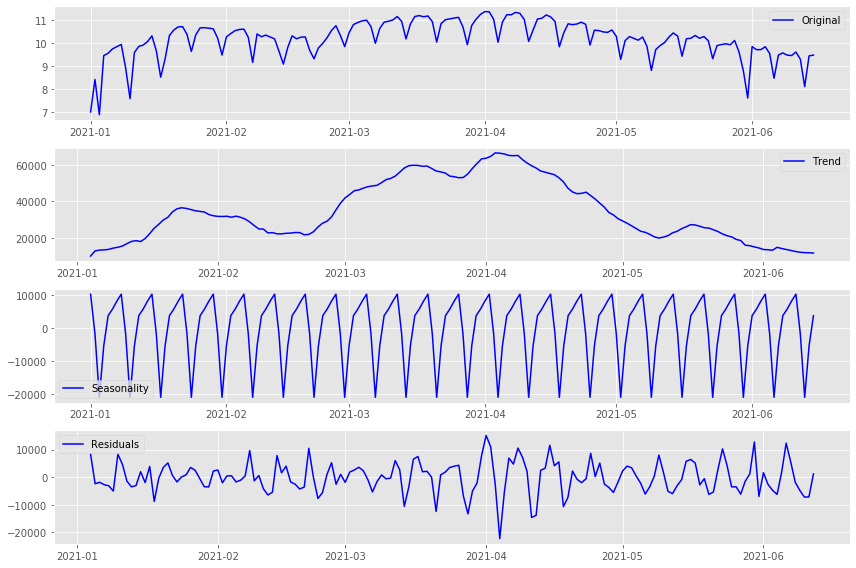

In [28]:
#showing Chicago as example
decompose(nyc_ts)

With each time series, there is a trend that increases and levels off in different ways. There is clear seasonality which may have to do with the majority of people receiving their vaccines on weekends.

## Time Series Modeling

Now that I have a thorough understanding of my data, I can start the modeling process.

I'm going to create a time series model for each city using statsmodels ARIMA. Instead of running the model several times to determine the best p,d,q parameters, I'm using auto arima to gridsearch the best parameters in a more automated format, evaluating on the best AIC score, and then plug them into an ARIMA model. 

The below function will perform the full process of finding parameters, fitting a model, making predictions, calculating error, and plotting results. I'll note that I've set d=1 in the model as I know my data is not stationary. I've also set seasonality to False knowing that I don't have enough data to determine seasonality. This will make the PDQ values 0. I also adjusted these in the inputs to auto arima to override defaults. 

In [24]:
def ts_model(ts, city):
    
    """
    Given a time series, defines a train-test split, runs an auto arima to gridsearch p,d,q values,
    inputs those into an ARIMA model, fits the model, runs forecasts and calculates RMSE.
    Plots the predictions against actuals. 
    """
    
    #getting train test splits
    cutoff = 136 # data-last 30 days
    train = ts[:cutoff]
    test = ts[cutoff:]
    
    #running auto arima
    auto_arima = pm.auto_arima(train, start_p=0, d=1, start_q=0, #d=1 as data is not stationary
                               start_P=0, start_D=0, start_Q=0,
                               m=12, seasonal=False, #there is no seasonality component 
                               trace=True, stepwise=True, n_fits=50)
    
    #getting pdq values from the output of auto arima
    params_dict = auto_arima.get_params()
    
    #running ARIMA model with best fit pdq's
    arima = ARIMA(train,
                  order=params_dict['order'],
                  enforce_stationarity=True,
                  enforce_invertibility=False)

    #fitting model 
    output = arima.fit()
    
    #making predictions on test set
    preds = output.predict(start=test.index[0], end=test.index[-1])
    
    #forecasting ahead
    forecast_steps = output.forecast(steps=40)
    
    # Computing RMSE
    pred_mean = output.get_prediction(start=test.index[0], dynamic=False).predicted_mean
    # pred_conf = pred.conf_int()

    rmse = round(np.sqrt(((pred_mean - test) ** 2).mean()),2)
    
    # Plotting real vs predicted values along with confidence interval
    rcParams['figure.figsize'] = 15, 6

    ax = ts.plot(label='Observed')

    forecast_steps.plot(ax=ax, label='Forecast', alpha=0.9)

    ax.set_xlabel('Date')
    ax.set_ylabel('Vaccinations')
    plt.legend()
    plt.title("Time Series Forecast for " + city +  " with an RMSE of {}".format(rmse))
    filename = 'Images/' + city + '_ts_forecast.png'
    plt.savefig(filename)
    plt.show()
    
    #plotting diagnostics to understand performance of model
    output.plot_diagnostics(figsize=(15, 10))
    plt.show()
    


Now I am going to run this for each city and analyze results.

__New York__

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3583.941, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3583.331, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3581.035, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3581.984, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3579.176, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3546.264, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3570.309, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3545.656, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3565.426, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3532.806, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3547.611, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3514.673, Time=0.33 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3514.274, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3512.537, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0]          

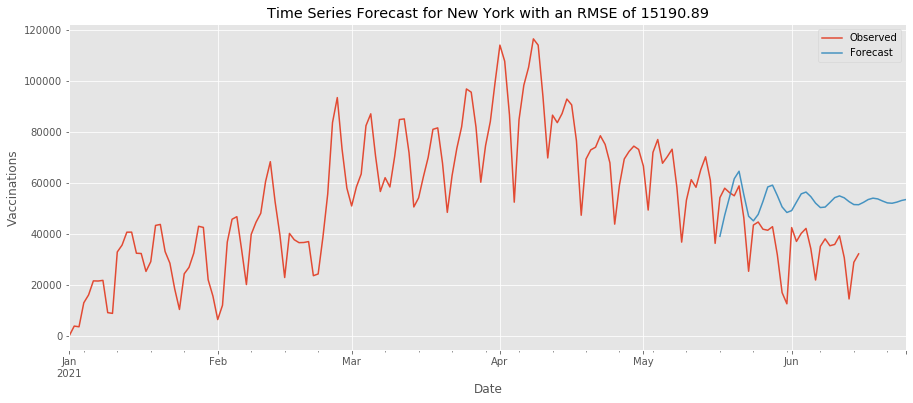

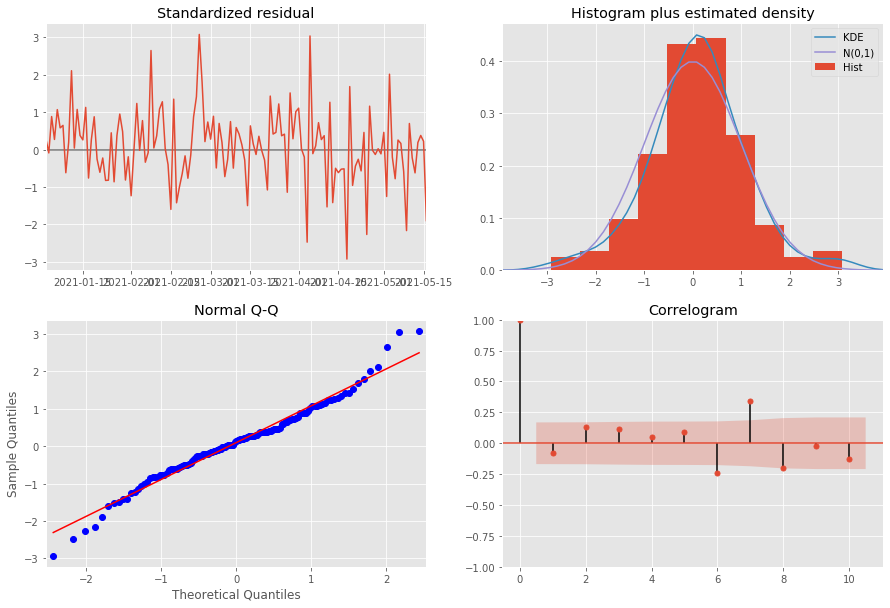

In [23]:
ts_model(nyc_ts, 'New York')

The New York ARIMA model has a high error - although it picks up on the oscillation of the weekly trend it trails off instead of showing a definitive direction, suggesting that vaccinations flatten out. 

The diagnostics plots show that the distribution is pretty uniform. Residuals mostly fluctuate around a mean of zero but appear to increase on the negative side further on. From the correlogram, there doesn't appear to be a clear pattern in residuals. 

__Chicago__

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2753.016, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2754.667, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2753.375, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2751.036, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2735.389, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2709.851, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2731.210, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2711.789, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2713.329, Time=1.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2707.911, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2706.146, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2719.796, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2709.947, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2705.004, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]          

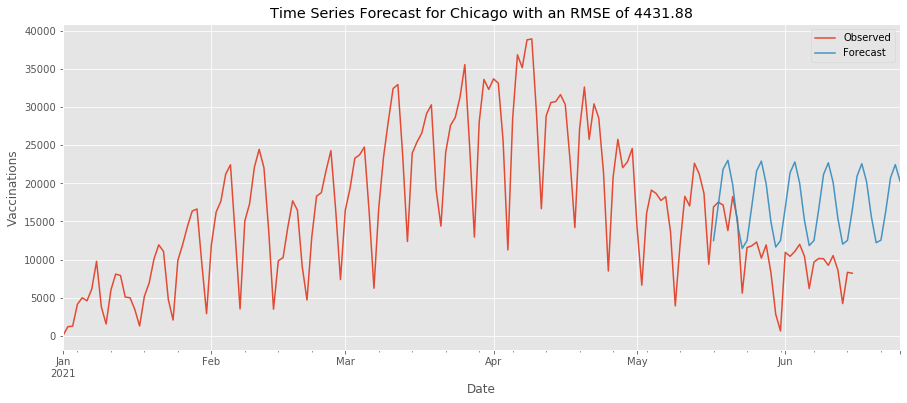

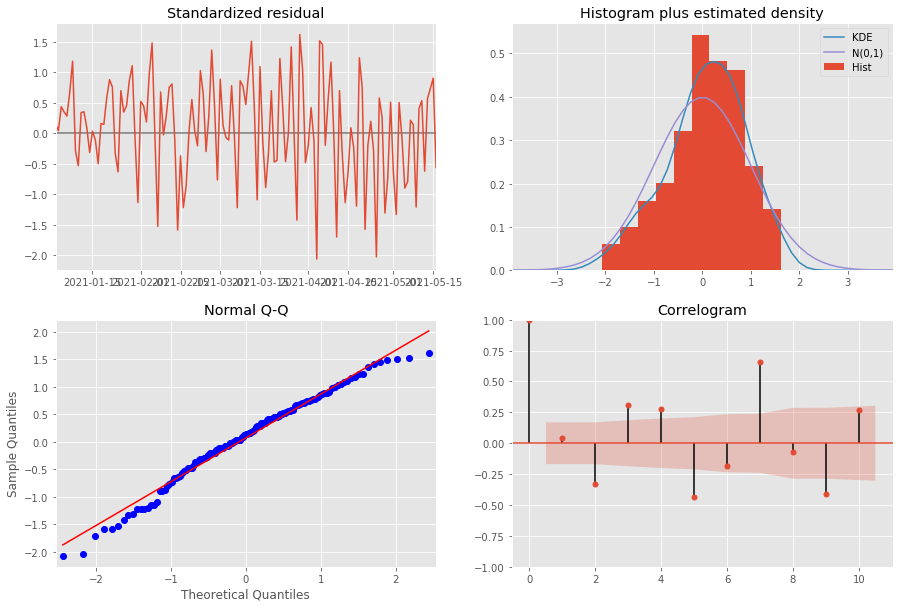

In [25]:
ts_model(chi_ts, 'Chicago')

The Chicago ARIMA model also picks up a clear pattern of weekly oscillation; however it does not trail off but remains consistent showing that it could not capture the downward trend that the actual data takes.

Diagnostics show a slightly skewed distribution, but residuals show high correlation to a 7 day lag, which is expected as the weekly trend is quite significant. The correlogram also shows negative correlations on a 5 and 9 day lag suggesting there are some other trends underlying in the data.

__Houston__

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2609.898, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2609.105, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2601.690, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2607.903, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2594.338, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2588.133, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2591.133, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2589.738, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2589.521, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2588.212, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2591.264, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2586.169, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2592.375, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

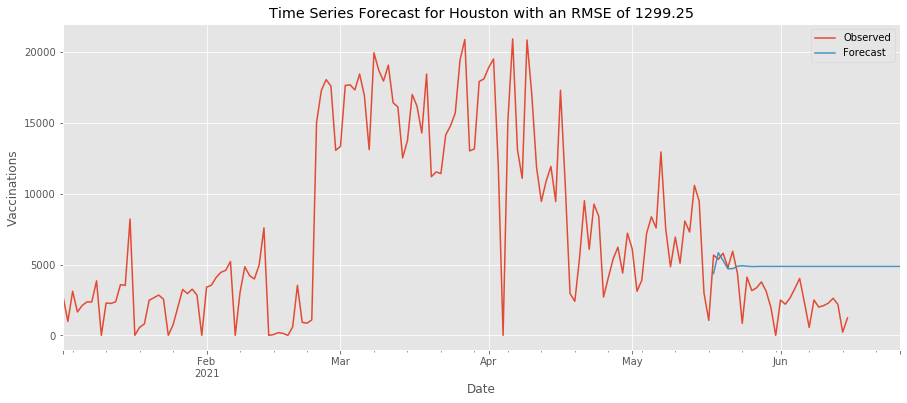

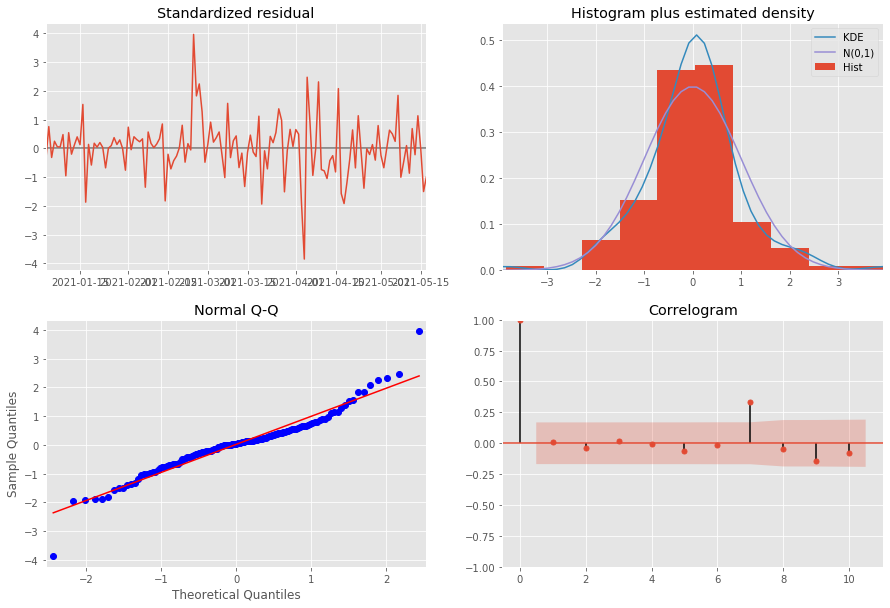

In [26]:
ts_model(hou_ts, 'Houston')

The Houston model is having a hard time picking up trends, possibly because the data is much more erratic than the previous cities'. The predictions flatten out quickly as it doesn't even have as strong of periodicity as the other data sets, and the time period of late February-early March is thrown off, mostly likely by the severe winter weather that majorly impacted Texas at that time. However, the overall RMSE is actually the lowest so far. There is almost no autocorrelation of the residuals except for the 7 day lag.

__Los Angeles__

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2958.117, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2959.086, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2957.059, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2956.126, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2949.800, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2919.577, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2940.834, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2920.888, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2927.479, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2940.736, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2938.754, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2917.698, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2947.799, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

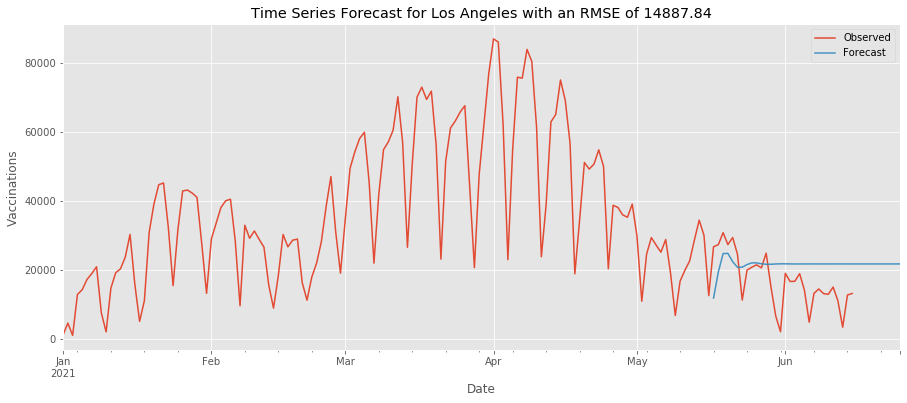

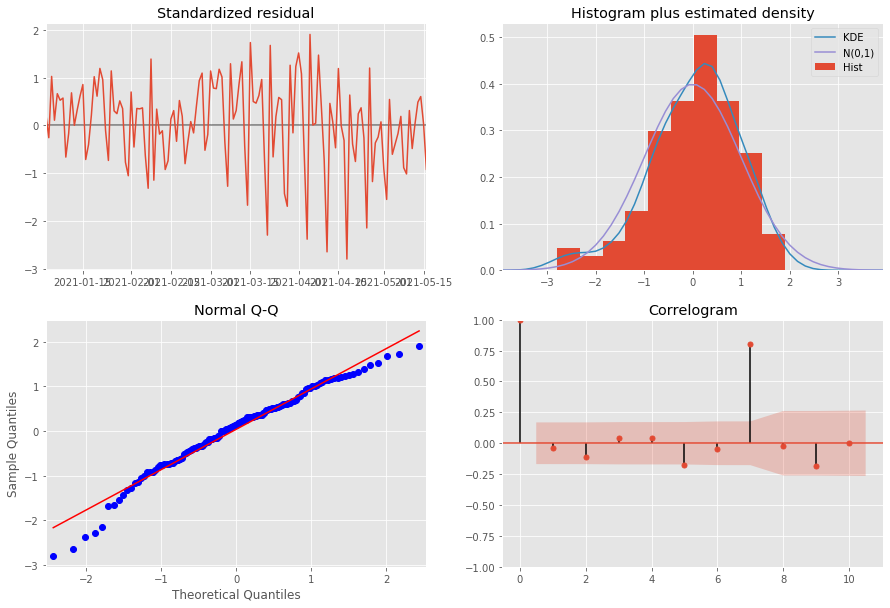

In [27]:
ts_model(la_ts, 'Los Angeles')

Finally, the Los Angeles ARIMA also quickly flattens out similar to Houston and the residuals are skewing negative. Looking back at the decomposition (below), the trend is a little less straightforward than the NYC and Chicago data - while there is still an arc it has a lot more wavering. It looks like the model is unable to read this trend. 

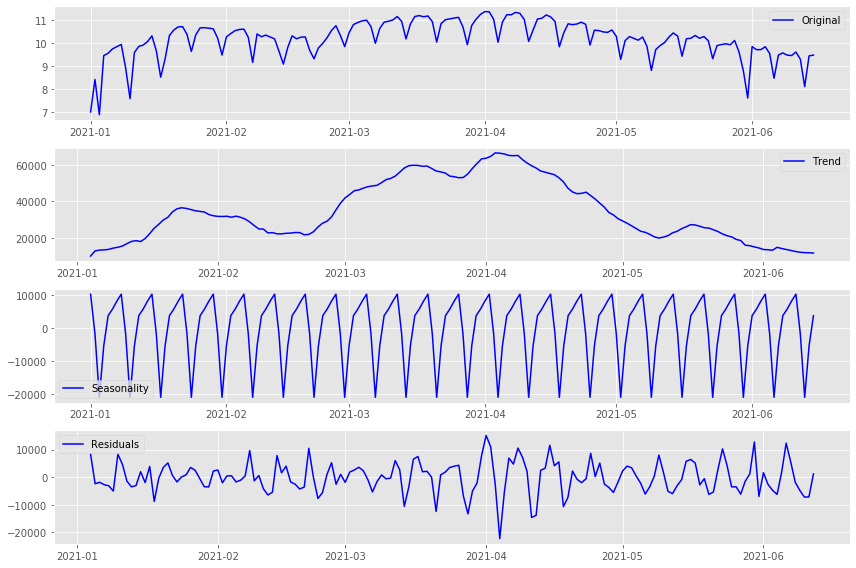

In [29]:
decompose(la_ts)

__Conclusion__

Overall, the patterns of vaccinations are proving difficult to capture for each city, with the ARIMA models mostly showing high error and forecasts that don't look too realistic. This may be due to the fact that there is not enough data and that the general direction of the data so far makes it hard to predict what's next. Since this is a problem that's happening in real time, we know that this is the latest data, and also that there are many other circumstances that factor into vaccinations that could be making the trends hard to predict. These could include weather, guidelines and availability for each state/city, and of course peoples' attitudes toward the vaccine in each region. 

That takes me into the next section, which will explore correlation of sentiment towards vaccines to vaccines administered in each city. 

## Correlating Vaccine Data to Social Media Sentiment

Finally, I will import the sentiment scored time series in order to compare how each city's social media sentiment correlates to its vaccination rates over time. 

My evaluation metric will be Pearson's R, which measures the linear correlation between two sets of data. To do this I will import my dataframes of sentiment over time that I ran in the Sentiment Evaluation notebook.

In [30]:
nyc_sent = pd.read_csv('data/nyc_sentiment.csv')
hou_sent = pd.read_csv('data/houston_sentiment.csv')
chi_sent = pd.read_csv('data/chicago_sentiment.csv')
la_sent = pd.read_csv('data/la_sentiment.csv')

Now I'm going to write a function that will concatenate the dataframes over the same time series, calculate Pearson's R, and plot the results.

In [31]:
def correlation_eval(sent_df, ts_df, city):
    
    """
    Takes in the sentiment score time series and the vaccine time series for each city 
    and concatenates them into one dataframe. Then calculates Pearsons R and p values.
    Plots the two time series and displays R and p values. 
    
    """
    
    #concatenating the sentiment and vaccine data
    corr_df = pd.concat([sent_df, ts_df.reset_index()['total_doses']], axis=1).set_index('date')
    corr_df.dropna(inplace=True)
    corr_df.index = pd.to_datetime(corr_df.index)
    
    #calculate pearsons r
    r, p = stats.pearsonr(corr_df['tb_polarity'], corr_df['total_doses'])
    r_round = round(r, 2)
    p_round = round(p, 4)

    # create figure and axis objects with subplots
    fig, ax = plt.subplots()
    
    #plot time series of vaccines
    ax.plot(corr_df['total_doses'], color="red", marker="o")
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("Total Doses", color="red", fontsize=14)

    # make a plot with different y-axis using second axis object
    ax2 = ax.twinx()
    ax2.plot(corr_df['tb_polarity'], color="blue", marker="o")
    ax2.set_ylabel("Sentiment Score", color="blue", fontsize=14)

    plt.title('{} Correlation of Vaccinations with Sentiment Score --- Pearsons R: {}:, P Value: {}'.format(city,
        r_round, p_round))
    
    filename = 'Images/ ' + city + 'correlation_plot.png'
    
    plt.savefig(filename)

    plt.show()

__New York__

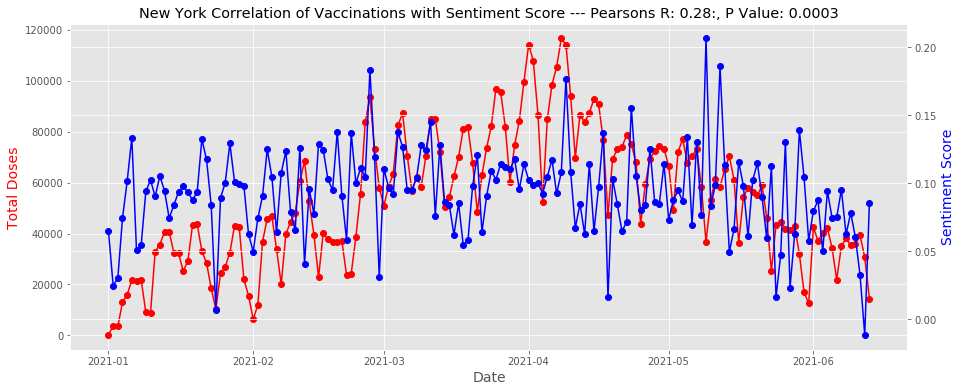

In [32]:
correlation_eval(nyc_sent, nyc_ts, 'New York')

The New York data shows a slight positive correlation and a significant p-value. We can see that while the sentiment score doesn't follow the same curve as sentiment is high before most people start getting vaccinated in New York, but we do see them decrease in a similar way towards the end of the time period. 

Overall, the two datasets do seem to be following the same trend, where positivity towards the vaccine early on helped fuel a spike in many people receiving it as soon as they could, followed by a drop off in interest.

__Chicago__

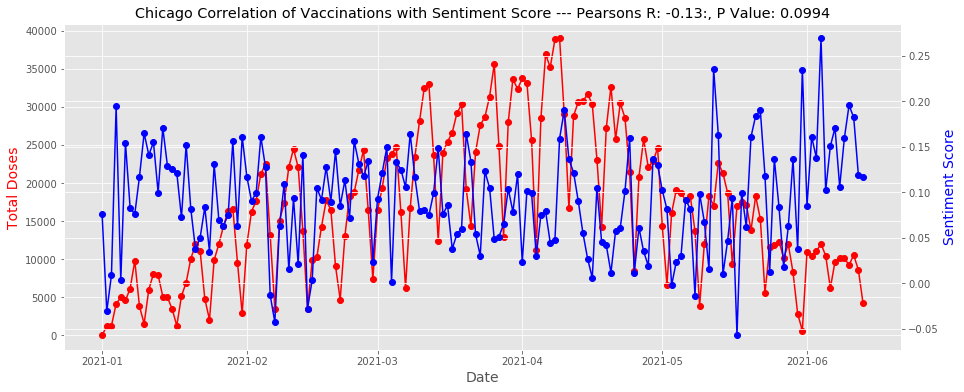

In [33]:
correlation_eval(chi_sent, chi_ts, 'Chicago')

Chicago actually sees a slight negative correlation, with the patterns of the two time series showing almost an inversion of each other. Potentially, there is a time lag correlation here with sentiment online fueling action on vaccinations as they became available to more people.

Below, I'm plotting a time lagged correlation - after trying a few different values,  I really only see a positive correlation around the 90 day lag.

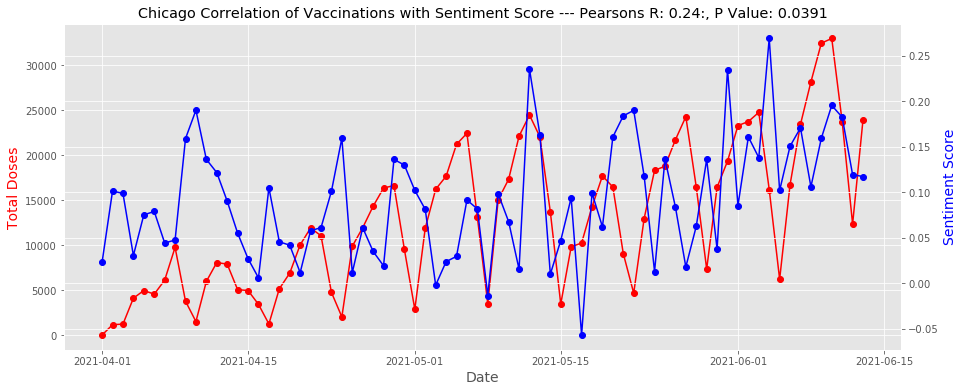

In [34]:
correlation_eval(chi_sent, chi_ts.shift(90), 'Chicago')

For the first half of the data, this may make sense as we see lots of conversation online about vaccines roughly three months before they become available to a significant amount of people. However, this starts to get questionable towards the end of the time series - sentiment score continues to go up while vaccines administered drop pretty sharply. Potentially having a few weeks more data will help us understand the relationship better.

__Houston__

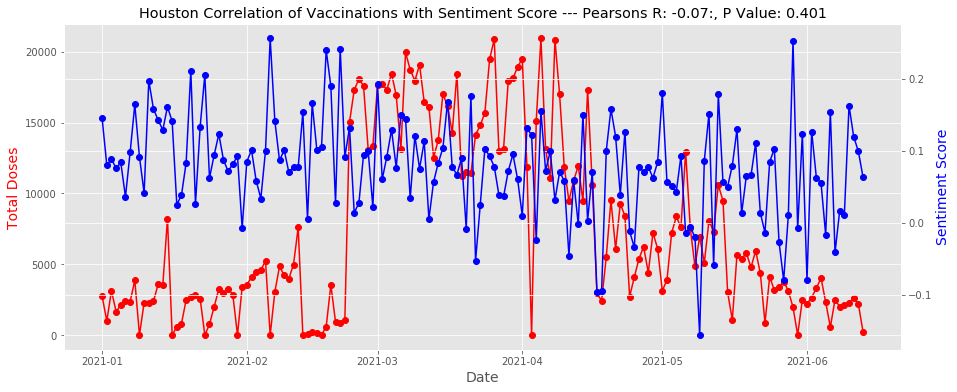

In [35]:
correlation_eval(hou_sent, hou_ts, 'Houston')

The sentiment score for Houston actually looks a bit more consistent over time compared to the others, although it falls more into neutral territory. We can see here that the population appears more hesitant toward the vaccine with sentiment trending more towards the negative than other cities. 
The calculation suggests there is really no correlation with vaccinations. There are definitely some other underlying trends here that could be pulled out from other data sources.

__Los Angeles__

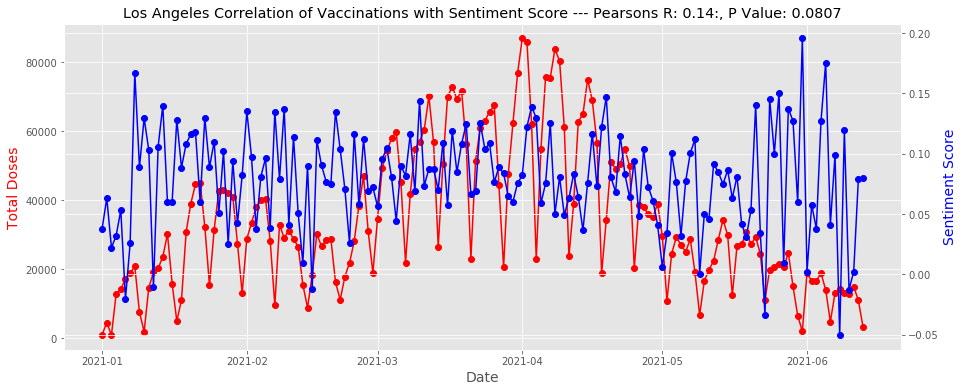

In [36]:
correlation_eval(la_sent, la_ts, 'Los Angeles')

LA also shows a slight positive correlation, even slighter than New York. The two datasets seem to be most correlated when vaccinations are most high. Sentiment remains high throughout and peaks as vaccines start to fall,  suggesting that attitudes remain positive as a high volume of people are vaccinated.

Sentiment reaches its highest as vaccines start to drop - perhaps those who got their vaccines are continuing to emphasize the positive results online to encourage others to get vaccinated as well. 

__Conclusion__

There are many different ways these two datasets can interact with each other. The correlation analysis shows that there is a different relationship between social media conversation around vaccines and vaccines administered over time for each city. 

Because we see social chatter at a high rate before much of the population was able to receive the vaccine, this definitely affected the correlation as well. Once more data is available, it will be interesting to see how the results develop as vaccinations level off.

## Learnings and Recommendations

Using time series analysis techniques to break down an examine trends, I was able to show how vaccinations administered in the most populous US cities trended over time since the beginning of 2021, when they started to be released. When looking back at the chart of all cities plotted together as well as their individual decompositions, it's evident that while they are following generally the same trend, there are nuances to each that could be further explored to help tailor the approach in each city. 

Using ARIMA models was streamlined with the help of auto arima as a gridsearch technique to select the best parameters. While there were some interesting results from the ARIMA model forecasts, it's recommended to continue to gather data to feed the models more of the trends that we are already seeing. 


Finally, a correlation analysis uncovered different relationships with each city and social media conversation, where some seemed to follow the same trend, some showed a lag, and some had no real correlation. For future work, I would recommend testing different approaches of labeling/scoring the data. While Textblob is an efficient solution it's likely not the most accurate one. 

# Thank you!